# Gaussian Mixture Model

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import pickle

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from collections import namedtuple

from loggers.train_logger import TrainLogger
from loggers.run_logger import RunLogger
import utils.file_io as io

import matplotlib as mpl
import matplotlib.pyplot as plt

%autoreload 2
%matplotlib notebook
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

In [2]:
from utils.distributions import GMM, gen_ring
from dynamics.dynamics import Dynamics

from models.gmm_model import GaussianMixtureModel

In [3]:
from models.params import GMM_PARAMS
from loggers.train_logger import TrainLogger
from main import train_setup, create_config
from config import NP_FLOAT


root_dir = 'gmm_logs'
params, hooks = train_setup(GMM_PARAMS, log_file=None,
                            root_dir=root_dir, run_str=False)
params['beta_init'] = 1. / 20
params['diag'] = True
params['skewed'] = True

--------------------------------------------------------------------------------
Starting training using L2HMC algorithm...
Creating directory: /Users/saforem2/ANL/l2hmc-qcd/gmm_logs/2019_09_09/2019_09_09_1551/


In [4]:
model = GaussianMixtureModel(params)

--------------------------------------------------------------------------------
INFO: Building graph for `GaugeModel`...
INFO: Creating input placeholders...
INFO: Creating `Dynamics`...
INFO: Building `run_ops`...
INFO: Calculating loss function...
INFO: Calculating gradients for backpropagation...
INFO: Done building graph. Took: 22.887644052505493s
--------------------------------------------------------------------------------


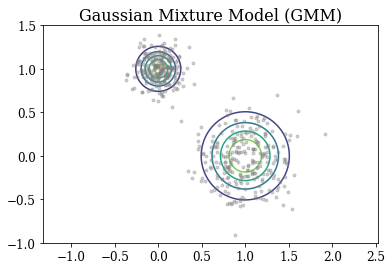

In [5]:
from plotters.plot_utils import plot_gaussian_contours
import matplotlib.pyplot as plt

target_samples = model.distribution.get_samples(5000)
mus = model.distribution.mus
covs = model.distribution.sigmas
#target_samples = dist.get_samples(500)
fig, ax = plt.subplots()
_ = plt.title('Gaussian Mixture Model (GMM)')
_ = ax.plot(target_samples[:500, 0], target_samples[:500, 1], ls='',
            marker='.', alpha=0.35, color='gray')
_ = plot_gaussian_contours(mus, covs,
                           x_lims=[-0.8, 2.0],
                           y_lims=[-1., 1.5],
                           res=400)
_ = plt.axis('equal')
_ = ax.set_xlim((-0.8, 2.0))
_ = ax.set_ylim((-1., 1.5))
_ = plt.show()
_ = fig.tight_layout()
#_ = fig.savefig('iso_gmm_exact.pdf', dpi=400, bbox_inches='tight')

In [6]:
train_logger = TrainLogger(model, params['log_dir'],
                           logging_steps=10, summaries=params['summaries'])
config, params = create_config(params)
net_weights_init = [1., 1., 1.]
samples_init = model.distribution.get_samples(model.num_samples)
beta_init = model.beta_init
checkpoint_dir = os.path.join(model.log_dir, 'checkpoints')
io.check_else_make_dir(checkpoint_dir)

Creating directory: /Users/saforem2/ANL/l2hmc-qcd/gmm_logs/2019_09_09/2019_09_09_1551/checkpoints
Creating directory: /Users/saforem2/ANL/l2hmc-qcd/gmm_logs/2019_09_09/2019_09_09_1551/training
Creating directory: /Users/saforem2/ANL/l2hmc-qcd/gmm_logs/2019_09_09/2019_09_09_1551/summaries/train


In [7]:
sess_kwargs = {
    'checkpoint_dir': checkpoint_dir,
    'hooks': hooks,
    'config': config,
    'save_summaries_secs': None,
    'save_summaries_steps': None,
}

#global_var_init = tf.global_variables_initializer()
#local_var_init = tf.local_variables_initializer()
#uninited = tf.report_uninitialized_variables()

sess = tf.train.MonitoredTrainingSession(**sess_kwargs)
tf.keras.backend.set_session(sess)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /Users/saforem2/ANL/l2hmc-qcd/gmm_logs/2019_09_09/2019_09_09_1551/checkpoints/model.ckpt.


In [8]:
model.beta_init

0.05

In [9]:
from trainers.gmm_trainer import GaussianMixtureModelTrainer
trainer = GaussianMixtureModelTrainer(sess, model, logger=train_logger)

In [ ]:
train_kwargs = {
    'samples_np': samples_init,
    'beta_np': 1./20,
    'net_weights': net_weights_init,
    'print_steps': 1.,
}

trainer.train(10000, **train_kwargs)

-------------------------------------------------------------------------
    STEP       LOSS     t/STEP    % ACC      EPS       BETA       LR    
-------------------------------------------------------------------------
    0/10000   -83.72     20.23    0.9416    0.201     0.05      0.001  
    1/10000   -100.7    0.2612     0.954    0.202     0.05      0.001  
    2/10000   -126.5    0.3171    0.9583   0.2029    0.05001  0.0009999
    3/10000   -99.44    0.2271    0.9646   0.2032    0.05001  0.0009999
    4/10000    -124     0.2138    0.9648   0.2038    0.05002  0.0009998
    5/10000   -130.9    0.1956    0.9675   0.2044    0.05002  0.0009998
    6/10000   -130.4    0.2085    0.9621   0.2052    0.05003  0.0009998
    7/10000   -130.8    0.1504    0.9609    0.206    0.05003  0.0009997
    8/10000   -141.2    0.3543    0.9631   0.2068    0.05004  0.0009997
    9/10000   -138.8    0.1626    0.9521   0.2077    0.05004  0.0009996
   10/10000   -146.8    0.1835    0.9529   0.2086    0.0500

  107/10000   -214.5    0.3402    0.9215   0.2802    0.05051  0.0009956
  108/10000   -196.8    0.2035     0.92    0.2806    0.05052  0.0009956
  109/10000   -213.2    0.1345    0.9162   0.2809    0.05052  0.0009956
  110/10000   -195.2    0.1478    0.9283   0.2812    0.05053  0.0009955
  111/10000   -221.5    0.4408    0.9013   0.2814    0.05053  0.0009955
  112/10000   -226.8     0.156    0.9143   0.2817    0.05054  0.0009954
  113/10000   -226.8    0.1583    0.9359    0.282    0.05054  0.0009954
  114/10000   -223.1    0.4276    0.9224   0.2822    0.05055  0.0009954
  115/10000   -215.3    0.2365    0.9322   0.2824    0.05055  0.0009953
  116/10000   -227.6    0.2542    0.9329   0.2826    0.05056  0.0009953
  117/10000   -201.8    0.3168    0.9176   0.2827    0.05056  0.0009952
  118/10000   -229.8     0.15     0.9249   0.2829    0.05057  0.0009952
  119/10000   -201.6    0.1739    0.9214   0.2829    0.05057  0.0009952
  120/10000   -212.6    0.4281    0.9277   0.2829    0.05058  0.

  218/10000   -210.1    0.2006    0.9227   0.2906    0.05106  0.0009911
  219/10000   -201.9    0.1849    0.9243   0.2904    0.05106  0.0009911
  220/10000   -228.2    0.2563    0.9228   0.2901    0.05107  0.0009911
  221/10000   -229.1     0.314    0.9274   0.2899    0.05107  0.000991 
  222/10000    -229     0.4963    0.9262   0.2898    0.05108  0.000991 
  223/10000   -234.4    0.2579    0.9266   0.2896    0.05108  0.0009909
  224/10000   -214.2    0.2875    0.9254   0.2895    0.05109  0.0009909
  225/10000   -216.1    0.2552    0.9353   0.2894    0.05109  0.0009909
  226/10000   -216.9    0.1588    0.9139   0.2892    0.0511   0.0009908
  227/10000   -206.4    0.1952    0.9325   0.2891    0.0511   0.0009908
  228/10000   -223.8     0.251    0.9343    0.289    0.05111  0.0009907
  229/10000   -224.1    0.1338    0.9372   0.2889    0.05111  0.0009907
  230/10000   -221.5    0.1023    0.9318   0.2887    0.05112  0.0009907
  231/10000   -229.4    0.1175    0.9289   0.2888    0.05112  0.

  329/10000   -230.3    0.3135    0.9217    0.291    0.05161  0.0009867
  330/10000   -227.3    0.2302    0.9141    0.291    0.05162  0.0009866
  331/10000   -205.5    0.1396    0.9252   0.2909    0.05162  0.0009866
  332/10000   -240.7     0.162    0.9244    0.291    0.05163  0.0009865
  333/10000   -232.3    0.2003    0.9115    0.291    0.05163  0.0009865
  334/10000    -214     0.1978    0.9126    0.291    0.05164  0.0009865
  335/10000   -213.2    0.1325    0.9233    0.291    0.05164  0.0009864
  336/10000   -205.4    0.1509    0.9216    0.291    0.05165  0.0009864
  337/10000   -231.7    0.1347     0.892   0.2909    0.05165  0.0009863
  338/10000   -240.8    0.1464    0.9003   0.2909    0.05166  0.0009863
  339/10000   -237.6     0.114    0.9134   0.2909    0.05166  0.0009863
  340/10000    -247     0.1229    0.9026    0.291    0.05167  0.0009862
  341/10000   -230.6    0.1313    0.9096   0.2909    0.05167  0.0009862
  342/10000   -222.2    0.5579     0.913   0.2908    0.05168  0.

  439/10000   -227.4    0.1587    0.9002   0.2933    0.05218  0.0009822
  440/10000   -214.8    0.1433    0.9138   0.2931    0.05218  0.0009822
  441/10000   -215.4    0.1517    0.9161    0.293    0.05219  0.0009822
  442/10000   -251.8    0.1435     0.904   0.2929    0.05219  0.0009821
  443/10000   -241.2    0.1193    0.9032   0.2929    0.0522   0.0009821
  444/10000   -239.7    0.1086    0.9112   0.2928    0.0522   0.000982 
  445/10000    -215     0.1283    0.9167   0.2928    0.05221  0.000982 
  446/10000   -212.4    0.1384    0.9138   0.2927    0.05221  0.000982 
  447/10000    -259     0.1212    0.9162   0.2926    0.05222  0.0009819
  448/10000   -238.8    0.1379     0.916   0.2925    0.05222  0.0009819
  449/10000   -223.4    0.1588    0.9103   0.2925    0.05223  0.0009818
  450/10000   -231.7    0.1419    0.9165   0.2924    0.05223  0.0009818
  451/10000   -212.9    0.1554    0.9236   0.2923    0.05224  0.0009818
  452/10000   -230.2    0.1935    0.9146   0.2922    0.05224  0.

  549/10000   -226.5    0.3393    0.8902   0.2962    0.05275  0.0009778
  550/10000   -231.4    0.2013    0.9201   0.2963    0.05276  0.0009778
  551/10000   -227.4    0.6331    0.9133   0.2963    0.05276  0.0009778
  552/10000   -240.8    0.3786    0.9086   0.2964    0.05277  0.0009777
  553/10000    -223     0.5373     0.916   0.2964    0.05277  0.0009777
  554/10000    -228     0.2692    0.9122   0.2965    0.05278  0.0009776
  555/10000   -240.9    0.1861    0.9059   0.2966    0.05278  0.0009776
  556/10000   -235.3    0.2488    0.9225   0.2965    0.05279  0.0009776
  557/10000   -224.2    0.1559     0.908   0.2964    0.05279  0.0009775
  558/10000   -253.7    0.5193    0.8865   0.2962    0.0528   0.0009775
  559/10000   -216.4    0.2575    0.9334    0.296    0.0528   0.0009774
  560/10000   -231.6    0.3855    0.9127   0.2957    0.05281  0.0009774
  561/10000    -230     0.1856    0.9088   0.2955    0.05281  0.0009774
  562/10000   -220.8    0.2051    0.9115   0.2953    0.05282  0.

  660/10000   -246.7    0.1192    0.9048   0.2955    0.05334  0.0009734
  661/10000   -257.6    0.1369    0.9018   0.2955    0.05335  0.0009734
  662/10000   -252.2    0.1979    0.9087   0.2955    0.05336  0.0009733
  663/10000   -253.4    0.1836    0.9214   0.2955    0.05336  0.0009733
  664/10000   -249.2    0.2157    0.9039   0.2953    0.05337  0.0009733
  665/10000   -223.8     0.152    0.9013    0.295    0.05337  0.0009732
  666/10000   -254.3    0.1621    0.9089    0.295    0.05338  0.0009732
  667/10000   -264.9    0.1394    0.9149   0.2948    0.05338  0.0009731
  668/10000   -268.6    0.1896    0.9067   0.2947    0.05339  0.0009731
  669/10000   -252.5    0.1573    0.9089   0.2947    0.05339  0.0009731
  670/10000   -258.1    0.1859    0.9267   0.2946    0.0534   0.000973 
  671/10000   -279.8    0.1467    0.8984   0.2946    0.0534   0.000973 
  672/10000   -263.5    0.1792    0.9037   0.2945    0.05341  0.0009729
  673/10000   -265.8    0.1196    0.8747   0.2945    0.05342  0.

  770/10000   -256.4    0.1444    0.8944   0.2968    0.05395  0.0009691
  771/10000    -255     0.3647    0.9176   0.2968    0.05395  0.000969 
  772/10000   -259.2     0.152    0.9163   0.2967    0.05396  0.000969 
  773/10000   -223.3    0.1979    0.9042   0.2967    0.05396  0.0009689
  774/10000   -248.4    0.1482    0.9083   0.2969    0.05397  0.0009689
  775/10000    -251     0.1796    0.8965    0.297    0.05397  0.0009689
  776/10000   -244.5    0.1538    0.8946   0.2971    0.05398  0.0009688
  777/10000   -257.9    0.1794    0.9001   0.2972    0.05398  0.0009688
  778/10000    -242     0.1967    0.9101   0.2972    0.05399  0.0009687
  779/10000   -232.9    0.2553    0.8918   0.2972     0.054   0.0009687
  780/10000   -245.9    0.3341    0.9013   0.2972     0.054   0.0009687
  781/10000   -252.9    0.1967    0.9026   0.2971    0.05401  0.0009686
  782/10000   -262.5    0.1907    0.9109   0.2971    0.05401  0.0009686
  783/10000   -252.4    0.1643    0.8976   0.2972    0.05402  0.

  880/10000   -243.1    0.1273     0.906   0.2971    0.05456  0.0009647
  881/10000   -231.8    0.1265    0.9149   0.2973    0.05457  0.0009647
  882/10000   -231.1    0.1457    0.9283   0.2975    0.05457  0.0009646
  883/10000   -251.5    0.1832    0.9119   0.2976    0.05458  0.0009646
  884/10000   -253.4     0.365     0.921   0.2978    0.05458  0.0009646
  885/10000   -253.8    0.1579    0.9121    0.298    0.05459  0.0009645
  886/10000   -252.1    0.2366    0.9067   0.2982    0.0546   0.0009645
  887/10000    -259     0.1905    0.9344   0.2984    0.0546   0.0009644
  888/10000   -238.5    0.1869    0.9144   0.2986    0.05461  0.0009644
  889/10000   -243.3    0.2886    0.9238    0.299    0.05461  0.0009644
  890/10000   -239.6    0.1845    0.8965   0.2993    0.05462  0.0009643
  891/10000   -239.3    0.4656    0.9064   0.2993    0.05462  0.0009643
  892/10000   -255.4    0.3132    0.9247   0.2993    0.05463  0.0009642
  893/10000   -254.7    0.3144    0.9237   0.2993    0.05463  0.

  990/10000   -248.7    0.1418    0.9089   0.3029    0.05519  0.0009604
  991/10000   -256.2    0.1406    0.8997   0.3029    0.0552   0.0009604
  992/10000   -235.3    0.1793    0.9156   0.3028    0.0552   0.0009603
  993/10000   -230.6    0.1856    0.9255   0.3028    0.05521  0.0009603
  994/10000   -262.9    0.1567    0.8947   0.3027    0.05521  0.0009602
  995/10000   -243.8    0.1908    0.9121   0.3024    0.05522  0.0009602
  996/10000   -258.8    0.1534    0.9242   0.3021    0.05523  0.0009602
  997/10000   -250.1    0.3465    0.9258   0.3017    0.05523  0.0009601
  998/10000   -268.8    0.2651    0.9048   0.3014    0.05524  0.0009601
INFO:tensorflow:global_step/global_step/sec: 4.12643
  999/10000   -248.4    0.3488    0.9148   0.3011    0.05524   0.00096 
-------------------------------------------------------------------------
    STEP       LOSS     t/STEP    % ACC      EPS       BETA       LR    
-------------------------------------------------------------------------
 1000/

 1100/10000   -239.9    0.1408    0.9265    0.302    0.05583  0.0009561


In [ ]:
trainer.logger.write_train_strings()

In [ ]:
samples_out = []
px_out = []

feed_dict = {
    model.x: None,
    model.beta: 1.,
    model.net_weights[0]: 1.,
    model.net_weights[1]: 1.,
    model.net_weights[2]: 1.,
    model.train_phase: False
}
samples = model.distribution.get_samples(model.num_samples)
num_steps = 100000
for i in range(num_steps):
    feed_dict.update({
        model.x: samples,
    })
    samples, px = sess.run([model.x_out, model.px], feed_dict=feed_dict)
    _px = np.mean(px)
    print(f'Step: {i} / {num_steps} \t px: {_px}')
    samples_out.append(samples)
    px_out.append(_px)

In [ ]:
samples_out = np.array(samples_out)
samples_out.shape

In [ ]:
%matplotlib notebook

In [ ]:
import matplotlib.pyplot as plt
target_samples = model.distribution.get_samples(5000)
#idx = 0
fig, axes = plt.subplots(nrows=4, ncols=5)
_idx = 0
for idx in range(4):
    for jdx in range(5):
        #_ = ax.plot(target_samples[:, 0], target_samples[:, 1],
        #            marker='o', alpha=0.6, ls='')
        _ = plot_gaussian_contours(mus, covs, x_lims=[-0.75, 1.75],
                                   y_lims=[-0.75, 1.5], res=400,
                                   ax=axes[idx, jdx])
        _ = axes[idx, jdx].plot(samples_out[-500:, _idx, 0],
                                samples_out[-500:, _idx, 1],
                                marker='.', alpha=0.7, ls='-')
        _idx += 1

In [ ]:
from scipy.stats import sem

In [ ]:
# NOTE: samples_out.shape = (chain_length, num_chains, 2)
#    Where chain_length = number of configurations output 
#    from MH Accept/Reject (using the trained sampler)
print(f'samples_out.shape: {samples_out.shape}\n\n')
samples_avg = samples_out.mean(axis=0) # get average (x, y) for each chain

# Avg `x`, `y` coordinates for each
# of the `num_chains` chains ran in parallel
_x, _y = samples_avg.T

# standard error of the mean
_x_err = sem(_x)  
_y_err =sem(_y)

print(f'avg_x: {_x.mean():.4g} +/- {_x_err:.4g}')
print(f'avg_y: {_y.mean():.4g} +/- {_y_err:.4g}')

In [ ]:
gmm_model.distribution.mus

In [ ]:
gmm_model.distribution.sigmas


In [ ]:
chain_length, num_chains, _ = samples_out.shape
fig, ax = plt.subplots()
_ = ax.plot(target_samples[:, 0], target_samples[:, 1], marker='.', alpha=0.4, ls='', color='lightgray')
_ = ax.plot(samples_out[-200:, idx, 0], samples_out[-200:, idx, 1], marker='.', alpha=0.4, ls='--', color='gray')
_ = ax.plot(_x.mean(), _y.mean(), marker='.', markersize=10, ls='', color='r', label=f'Avg. over {num_chains} ran for {chain_length} steps')
_ = ax.plot(0.5, 0.5, marker='s', markersize=10, ls='', color='blue', label=f'True avg.', fillstyle='none')
_ = ax.legend(loc='best')

#print(f'<x> = {_x.mean():.3g} +/- {_x_err:.3g}')
#print(f'<y> = {_y.mean():.3g} +/- {_y_err:.3g}')

In [ ]:
_x, _y = samples_avg0.T

In [ ]:
_x.shape

In [ ]:
fig, ax = plt.subplots()
ax.plot(samples_avg0[:, 0], samples_avg0[:, 1], marker='.', ls='', color='k')
ax.plot(_x.mean(), _y.mean(), marker='X', ls='', color='r', markersize=5.)
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))

In [ ]:
_x.mean(), _y.mean()

In [ ]:
gmm_model.means

In [ ]:
target_x, target_y = gmm_model.means.T

In [ ]:
target_x.mean(), target_y.mean()

In [ ]:
sample_idx = 0
#data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 3]], 200)
data = samples_out[:, sample_idx]
x, y = data.T

In [ ]:
data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 3]], 200)
data.shape

In [ ]:
means1, means2 = gmm_model.means
means1

In [ ]:
gmm_model.means

In [ ]:
# Create a figure with 6 plot areas
from scipy.stats import kde

means1, means2 = gmm_model.means
    
def make_2d_density_plots(chain, name='', out_file=None):
    print(f'Chain: {name}')
    x, y = chain.T
    #data = samples_out[:, idx]
    #x, y = data.T
    
    fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(21, 5))

    # Everything sarts with a Scatterplot
    _ = axes[0].set_title('Scatterplot')
    _ = axes[0].plot(x, y, 'ko')
    _ = axes[0].plot(means1[0], means1[1], marker='x', markersize=5., color='red')
    _ = axes[0].plot(means2[0], means2[1], marker='x', markersize=5., color='red')
    # As you can see there is a lot of overplottin here!

    # Thus we can cut the plotting window in several hexbins
    nbins = 20
    _ = axes[1].set_title('Hexbin')
    _ = axes[1].hexbin(x, y, gridsize=nbins, cmap=plt.cm.BuGn_r)
    _ = axes[1].plot(means1[0], means1[1], marker='x', markersize=5., color='red')
    _ = axes[1].plot(means2[0], means2[1], marker='x', markersize=5., color='red')

    # 2D Histogram
    _ = axes[2].set_title('2D Histogram')
    _ = axes[2].hist2d(x, y, bins=nbins, cmap=plt.cm.BuGn_r)
    _ = axes[2].plot(means1[0], means1[1], marker='x', markersize=5., color='red')
    _ = axes[2].plot(means2[0], means2[1], marker='x', markersize=5., color='red')

    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    k = kde.gaussian_kde(chain.T)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # plot a density
    _ = axes[3].set_title('Calculate Gaussian KDE')
    _ = axes[3].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.BuGn_r)
    _ = axes[3].plot(means1[0], means1[1], marker='x', markersize=5., color='red')
    _ = axes[3].plot(means2[0], means2[1], marker='x', markersize=5., color='red')

    # add shading
    _ = axes[4].set_title('2D Density with shading')
    _ = axes[4].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
    _ = axes[4].plot(means1[0], means1[1], marker='x', markersize=5., color='red')
    _ = axes[4].plot(means2[0], means2[1], marker='x', markersize=5., color='red')

    # contour
    _ = axes[5].set_title('Contour')
    _ = axes[5].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
    _ = axes[5].contour(xi, yi, zi.reshape(xi.shape) )
    _ = axes[5].plot(means1[0], means1[1], marker='x', markersize=5., color='red')
    _ = axes[5].plot(means2[0], means2[1], marker='x', markersize=5., color='red')
    _ = plt.suptitle(f'chain.shape: {chain.shape}', fontsize=16)
    
    if out_file is not None:
        print(f'Saving figure to: {out_file}')
        plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
all_samples = samples_out.reshape(-1, 2)
all_samples.shape

In [ ]:
out_dir = '../figures/gmm_figures/'
for idx in range(5):
    out_file = os.path.join(*out_dir.split('/'), f'gmm_density_plots_{idx}.pdf')
    _ = make_2d_density_plots(samples_out[:, idx], name=f'{idx} idx', out_file=out_file)
    
all_file = os.path.join(*out_dir.split('/'), 'gmm_density_plots_all_chains.pdf')
_ = make_2d_density_plots(all_samples, name='all chains', out_file=all_file)

target_file = os.path.join(*out_dir.split('/'), f'gmm_density_plots_target_dist.pdf')
_ = make_2d_density_plots(target_samples, name='target distribution', out_file=target_file)

In [ ]:
all_file = os.path.join(*out_dir.split('/'), 'gmm_density_plots_all_chains2.pdf')
_ = make_2d_density_plots(all_samples[-20000:], name='all chains2', out_file=all_file)

In [ ]:
from models.gmm_model import distribution_arr

x_dim = 2
sigma = 0.02
centers = 1
means = np.zeros((x_dim, x_dim), dtype=np.float32)
for i in range(x_dim):
    means[i::x_dim, i] = centers
cov_mtx = sigma * np.eye(x_dim).astype(np.float32)
covs = np.array([cov_mtx] * x_dim).astype(np.float32)
dist_arr = distribution_arr(x_dim, 2)
gmm_dist = GMM(means, covs, dist_arr)

gmm_mus = np.array(gmm_dist.mus)
gmm_diffs = gmm_mus[1:] - gmm_mus[:-1, :]
gmm_distances = [np.sqrt(np.dot(d, d.T)) for d in gmm_diffs]
gmm_distances

In [ ]:
gmm_samples = gmm_dist.get_samples(500)
fig, ax = plt.subplots()
ax.plot(gmm_samples[:,0], gmm_samples[:,1], marker='o', ls='', alpha=0.75)
plt.show()

In [ ]:
k()

In [ ]:
zi.shape

In [ ]:
xi.shape

## OLD

In [ ]:
def distribution_arr(x_dim, num_distributions):
    """Create array describing likelihood of drawing from distributions."""
    if num_distributions > x_dim:
        pis = [1. / num_distributions] * num_distributions
        pis[0] += 1 - sum(pis)
    if x_dim == num_distributions:
        big_pi = round(1.0 / num_distributions, x_dim)
        pis = num_distributions * [big_pi]
    else:
        big_pi = (1.0 / num_distributions) - x_dim * 1e-16
        pis = num_distributions * [big_pi]
        small_pi = (1. - sum(pis)) / (x_dim - num_distributions)
        pis.extend((x_dim - num_distributions) * [small_pi])

    return np.array(pis, dtype=NP_FLOAT)

In [ ]:
NP_FLOAT = np.float32
x_dim = 2
centers = 1.
sigma = 0.05
num_distributions = 2

means = np.zeros((x_dim, x_dim), dtype=NP_FLOAT)
cov_mtx = sigma * np.eye(x_dim).astype(NP_FLOAT)
covs = np.array([cov_mtx] * x_dim).astype(NP_FLOAT)
dist_arr = distribution_arr(x_dim, num_distributions)
distribution = GMM(means, covs, dist_arr)

In [ ]:
num_samples = 100
dynamics_kwargs = {
    'eps': 0.2,
    'hmc': False,
    'x_dim': x_dim,
    'batch_size': num_samples,
    '_input_shape': (num_samples, x_dim),
    'eps_trainable': True,
    'network_arch': 'generic',
    'num_steps': 10,
    'use_bn': False,
    'dropout_prob': 0.,
    'num_hidden1': 10,
    'num_hidden2': 10,
    'zero_translation': False
}
samples = distribution.get_samples(100)
potential_fn = distribution.get_energy_function()
dynamics = Dynamics(potential_fn=potential_fn, **dynamics_kwargs)

In [ ]:
from config import TF_FLOAT, GLOBAL_SEED
x = tf.placeholder(dtype=TF_FLOAT, shape=(num_samples, x_dim), name='x')
beta = tf.placeholder(dtype=TF_FLOAT, shape=(), name='beta')
scale_weight = tf.placeholder(dtype=TF_FLOAT, shape=(), name='scale_weight')
transf_weight = tf.placeholder(dtype=TF_FLOAT, shape=(), name='transformation_weight')
transl_weight = tf.placeholder(dtype=TF_FLOAT, shape=(), name='translation_weight')
net_weights = [scale_weight, transl_weight, transf_weight]
train_phase = tf.placeholder(tf.bool, name='is_training')
#metric_fn = _metric_fn
z = tf.random_normal(tf.shape(x), dtype=TF_FLOAT, seed=GLOBAL_SEED, name='z')

In [ ]:
x_dynamics = dynamics.apply_transition(x, beta, net_weights, train_phase, save_lf=True)
z_dynamics = dynamics.apply_transition(z, beta, net_weights, train_phase, save_lf=False)

In [ ]:
x_proposed = x_dynamics['x_proposed']
x_out = x_dynamics['x_out']
px = x_dynamics['accept_prob']

z_proposed = z_dynamics['x_proposed']
pz = z_dynamics['accept_prob']

v1 = (tf.reduce_sum(tf.square(x - x_proposed), axis=1) * px) + 1e-4
v2 = (tf.reduce_sum(tf.square(z - z_proposed), axis=1) * pz) + 1e-4
scale = 0.1
loss = 0.
loss += scale * (tf.reduce_mean(1.0 / v1) + tf.reduce_mean(1.0 / v2))
loss += (- tf.reduce_mean(v1) - tf.reduce_mean(v2)) / scale

In [ ]:
# Training parameters
global_step = tf.Variable(0., name='global_step', trainable=False)
learning_rate = tf.train.exponential_decay(1e-3, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

In [ ]:
n_steps = 5000
n_samples = 100

samples = np.random.randn(n_samples, x_dim)

sess = tf.Session(config=tf.ConfigProto())
sess.run(tf.global_variables_initializer())

In [ ]:
for t in range(n_steps):
    tmp = 9.0*(1 - t/float(n_steps)) + 1
    _, loss_, samples, px_, lr_ = sess.run([
        train_op,
        loss,
        x_out,
        px,
        learning_rate
    ], {x: samples, beta: 1./tmp,
        scale_weight: 1., transf_weight: 1., transl_weight: 1., train_phase: True})

    print('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f, Temp: %.4f' % (t, n_steps, loss_, np.mean(px_), lr_, tmp))

In [ ]:
# Squared jumped distance
v1 = (tf.reduce_sum(tf.square(x - Lx), axis=1) * px) + 1e-4
v2 = (tf.reduce_sum(tf.square(z - Lz), axis=1) * pz) + 1e-4
scale = 0.1

# Update loss
loss = 0.
loss += scale * (tf.reduce_mean(1.0 / v1) + tf.reduce_mean(1.0 / v2))
loss += (- tf.reduce_mean(v1) - tf.reduce_mean(v2)) / scale

In [ ]:
def _metric_fn(x1, x2):
    return tf.square(x1 - x2)

def _std_loss(inputs, metric_fn=_metric_fn):
    eps = 1e-4
    prob = inputs['prob']
    init = inputs['init']
    proposed = inputs['proposed']
    std_loss = tf.reduce_sum(metric_fn(init, proposed), axis=1)
    std_loss *= prob
    std_loss = tf.add(std_loss, eps, name='std_loss')
    
    return std_loss
    
def loss(inputs, metric_fn=_metric_fn):
    x_inputs = {
        'prob': inputs['px'],
        'init': inputs['x_init'],
        'proposed': inputs['x_proposed'],
    }
    z_inputs = {
        'prob': inputs['pz'],
        'init': inputs['z_init'],
        'proposed': inputs['z_proposed'],
    }
    
    ls = 0.1
    std_weight = 1.
    with tf.name_scope('std_loss'):
        with tf.name_scope('x_loss'):
            x_loss = _std_loss(x_inputs)
        with tf.name_scope('z_loss'):
            z_loss = _std_loss(z_inputs)
            
        with tf.name_scope('total_std_loss'):
            loss = (ls * (1. / x_loss + 1. / z_loss)
                    - (x_loss - z_loss) / ls) * std_weight
            std_loss = tf.reduce_mean(loss, axis=0, name='std_loss')
            
    return std_loss

In [ ]:
from config import GLOBAL_SEED
TF_FLOAT = tf.float32
x = tf.placeholder(dtype=TF_FLOAT, shape=(num_samples, x_dim), name='x')
beta = tf.placeholder(dtype=TF_FLOAT, shape=(), name='beta')
scale_weight = tf.placeholder(dtype=TF_FLOAT, shape=(), name='scale_weight')
transf_weight = tf.placeholder(dtype=TF_FLOAT, shape=(), name='transformation_weight')
transl_weight = tf.placeholder(dtype=TF_FLOAT, shape=(), name='translation_weight')
net_weights = [scale_weight, transl_weight, transf_weight]
train_phase = tf.placeholder(tf.bool, name='is_training')
metric_fn = _metric_fn
z = tf.random_normal(tf.shape(x), dtype=TF_FLOAT, seed=GLOBAL_SEED, name='z')

In [ ]:
x_dynamics = dynamics.apply_transition(x, beta, net_weights, train_phase, save_lf=True)
z_dynamics = dynamics.apply_transition(z, beta, net_weights, train_phase, save_lf=False)

In [ ]:
inputs = {
    'x_init': x,
    'z_init': z,
    'px': x_dynamics['accept_prob'],
    'pz': z_dynamics['accept_prob'],
    'x_proposed': x_dynamics['x_proposed'],
    'z_proposed': z_dynamics['x_proposed']
}
loss = loss(inputs)

In [ ]:
grads = tf.gradients(loss, dynamics.trainable_variables)

In [ ]:
lr_init = 1e-3
lr_decay_steps = 1000
lr_decay_rate = 0.96

x_out = x_dynamics['x_out']
px = x_dynamics['accept_prob']
global_step = tf.train.get_or_create_global_step()
lr = tf.train.exponential_decay(lr_init, global_step,
                                lr_decay_steps, lr_decay_rate,
                                staircase=False,
                                name='learning_rate')
optimizer = tf.train.AdamOptimizer(lr)
grads_and_vars = zip(grads, dynamics.trainable_variables)
with tf.control_dependencies([loss, *dynamics.updates]):
    train_op = optimizer.apply_gradients(grads_and_vars,
                                         global_step,
                                         'train_op')

In [ ]:
def update_beta(self, step, **kwargs):
    """Returns new beta to follow annealing schedule."""
    beta_init = kwargs.get('beta_init', None)
    beta_final = kwargs.get('beta_final', None)
    train_steps = kwargs.get('train_steps', None)

    temp = ((1. / beta_init - 1. / beta_final)
            * (1. - step / float(train_steps))
            + 1. / beta_final)
    new_beta = 1. / temp

    return new_beta


In [ ]:
from trainers.trainer import GaussianMixtureModelTrainer